<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [100]:
!pip install datasets

Импорт необходимых библиотек

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

from IPython.display import clear_output


In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fluke\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [4]:
# Загрузим датасет
dataset = load_dataset('imdb')

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [5]:
sentences = []
word_threshold = 32

for review in dataset['train']['text']:
    sentences_in_rewiew = sent_tokenize(review.lower())
    for sentence in sentences_in_rewiew:
        if len(word_tokenize(sentence))<word_threshold:
            sentences.extend([sentence])

In [107]:
print("Всего предложений:", len(sentences))

Всего предложений: 194504


Посчитаем для каждого слова его встречаемость.

In [ ]:
words = Counter()

for sentence in sentences:
    for word in word_tokenize(sentence):
        words[word]+=1

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [7]:
vocab_size = 40000
vocab = {word for word, _ in words.most_common(vocab_size)}

In [8]:
vocab.add('<unk>')
vocab.add('<bos>')
vocab.add('<eos>')
vocab.add('<pad>')

In [9]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [10]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [11]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [12]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind[word] for word in word_tokenize(self.data[idx]) if word in word2ind]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [13]:
def collate_fn_with_padding(input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [14]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [15]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [16]:
def show_loss_and_perplexity_graph(losses, perplexities): # Создание двух графиков
    epochs = np.arange(len(losses))
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))  
    
    axs[0].plot(epochs, losses, color='blue') 
    axs[0].set_title('Losses')
    axs[0].set_xlabel('Epoch')
    
    axs[1].plot(epochs, perplexities, color='red') 
    axs[1].set_title('Perplexity')
    axs[1].set_xlabel('Epoch')
    
    plt.tight_layout()  
    plt.show()

In [17]:
def train_model(model, optimizer, criterion, num_epoch=25):
    losses = []
    perplexities = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}'):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten(start_dim=0, end_dim=1))
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            
        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities.append(evaluate(model, criterion, eval_dataloader))
        clear_output(wait=True)
        if len(losses)>1 and len(perplexities)>1:
            print(f'Min Loss = {min(losses)}, Min Perplexity = {min(perplexities)}')
            show_loss_and_perplexity_graph(losses, perplexities)

    return model

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [21]:
class LanguageModel(nn.Module): # Базовая модель
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch) 
        output, _ = self.rnn(embeddings) 
        output = self.dropout(self.linear(self.non_lin(output)))
        projection = self.projection(self.non_lin(output))

        return projection

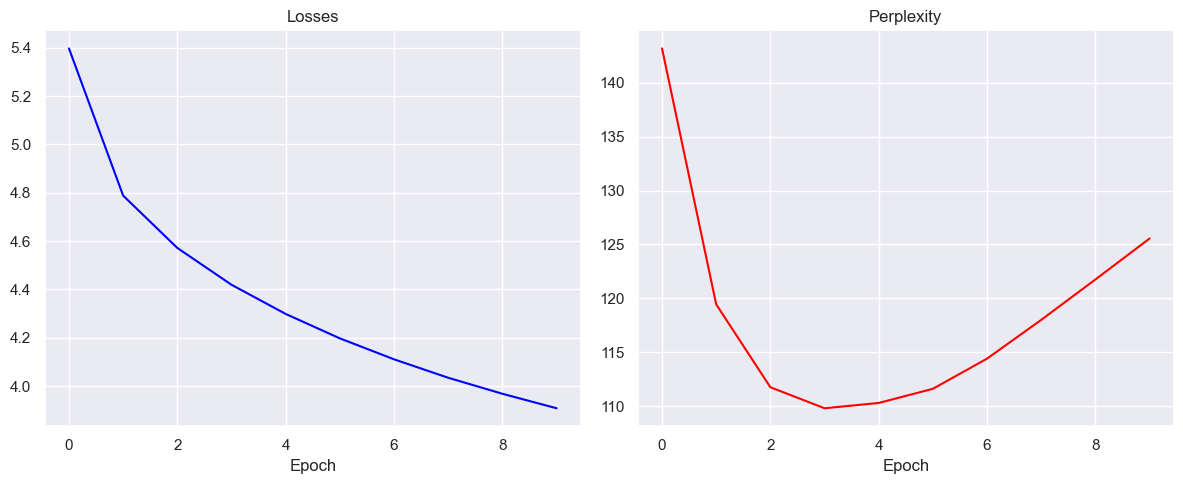

In [122]:
model = LanguageModel(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

model = train_model(model, optimizer, criterion, num_epoch=10)

Min Loss = 3.311605298205426, Min Perplexity = 103.55909222050717


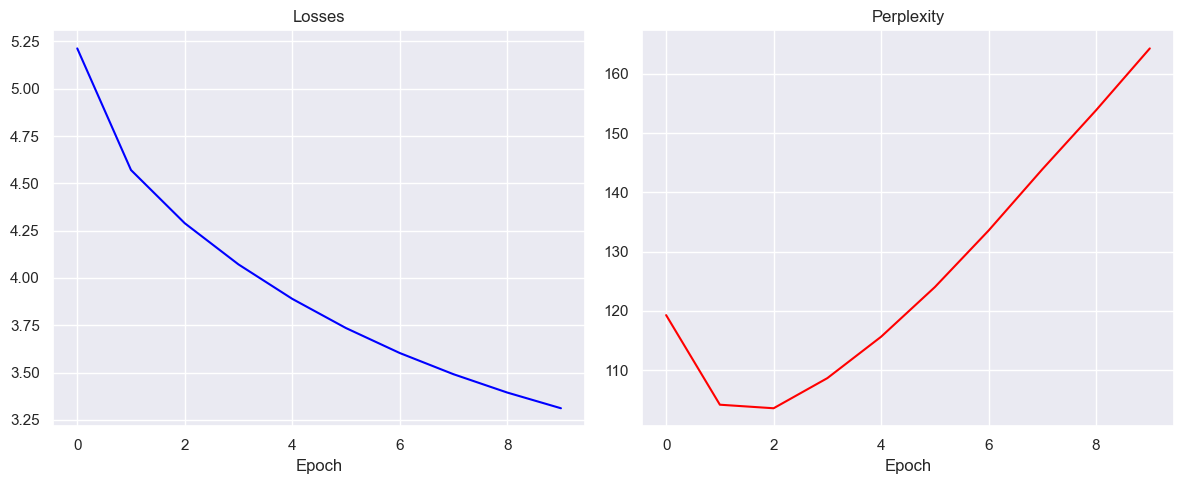

In [22]:
model = LanguageModel(hidden_dim=512, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

model = train_model(model, optimizer, criterion, num_epoch=10)

Минимальное значение перплексити 109

In [24]:
class LanguageModel_rnn_layers2(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True, num_layers=2) # Добавил 2 слой рнн
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch) 
        output, _ = self.rnn(embeddings) 
        output = self.dropout(self.linear(self.non_lin(output))) 
        projection = self.projection(self.non_lin(output))  

        return projection

Min Loss = 4.206552973507266, Min Perplexity = 111.89757482629074


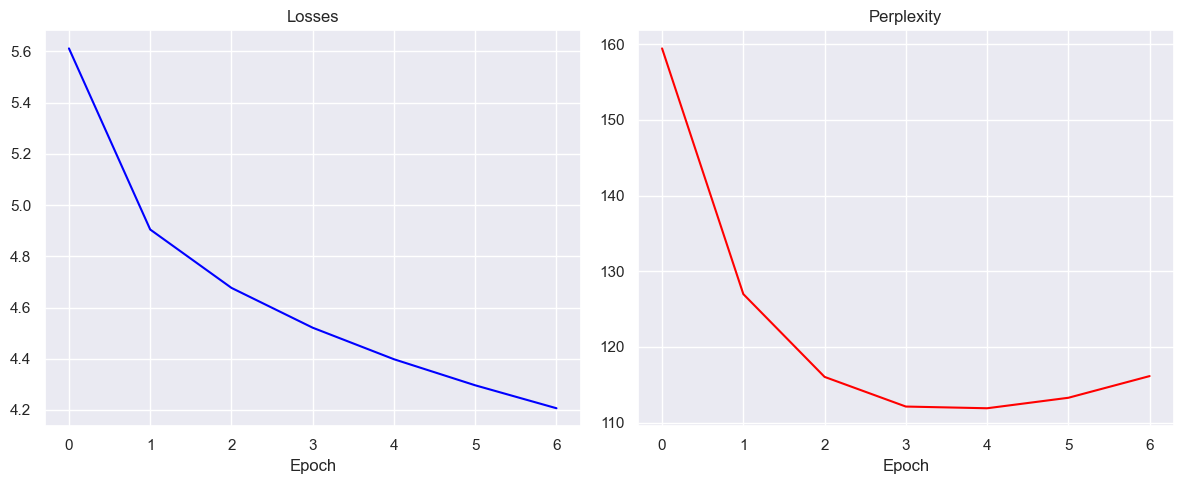

Training epoch 7:   0%|          | 0/1216 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [25]:
model = LanguageModel_rnn_layers2(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

model = train_model(model, optimizer, criterion, num_epoch=10)

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [18]:
class LanguageModel_LSTM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True) # Заменил GRU на LSTM
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch) 
        output, _ = self.rnn(embeddings) 
        output = self.dropout(self.linear(self.non_lin(output))) 
        projection = self.projection(self.non_lin(output))  

        return projection

Min Loss = 3.8718416106544042, Min Perplexity = 106.17272527594315


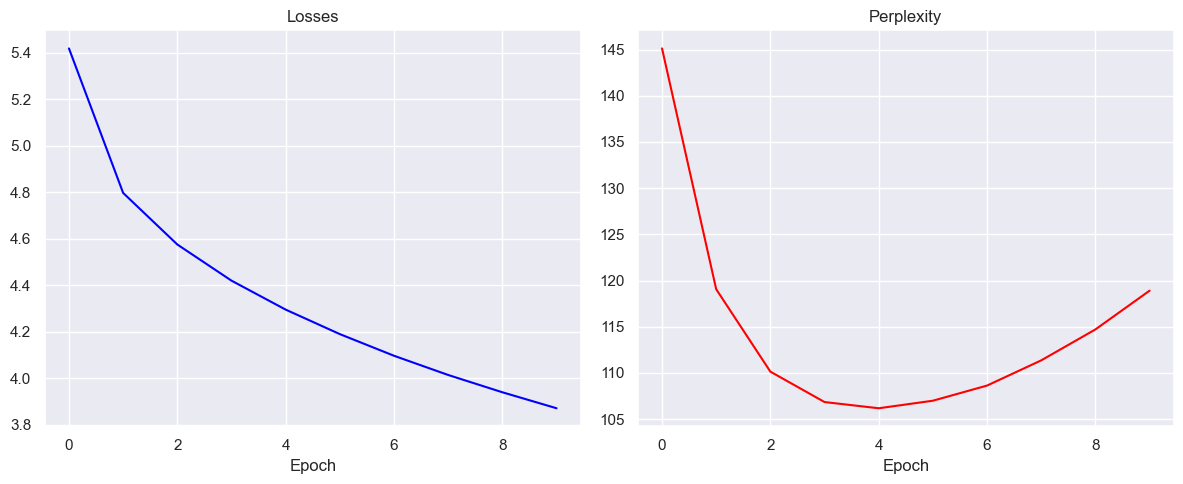

In [131]:
model = LanguageModel_LSTM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

model = train_model(model, optimizer, criterion, num_epoch=10)

Min Loss = 3.531434228545741, Min Perplexity = 101.8956880569458


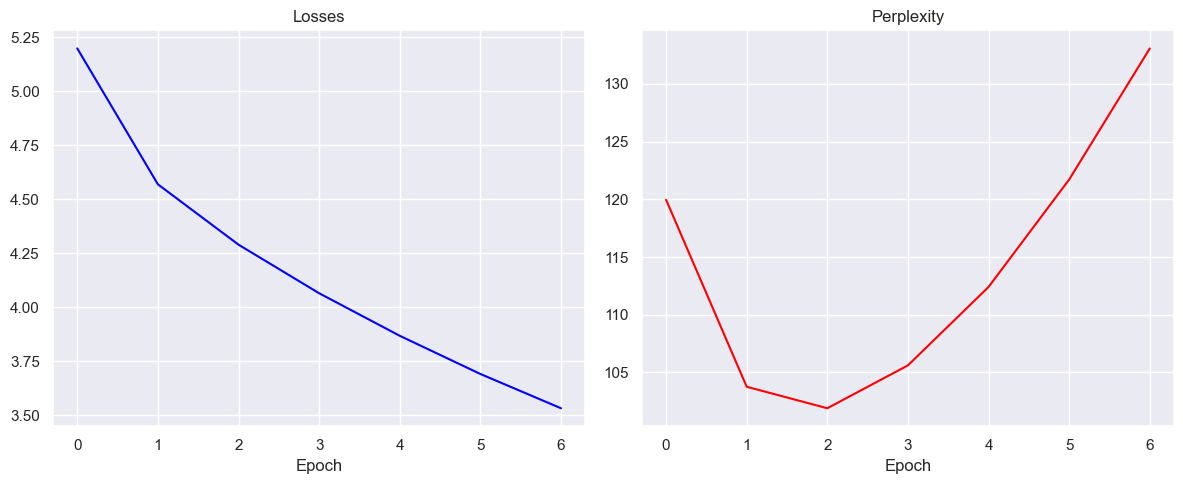

Training epoch 7:   0%|          | 0/1216 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [132]:
model = LanguageModel_LSTM(hidden_dim=512, vocab_size=len(vocab)).to(device) # Увеличил вв 2 раза скрытый слой
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

model = train_model(model, optimizer, criterion, num_epoch=10)

Min Loss = 4.327923457873495, Min Perplexity = 110.58686271466706


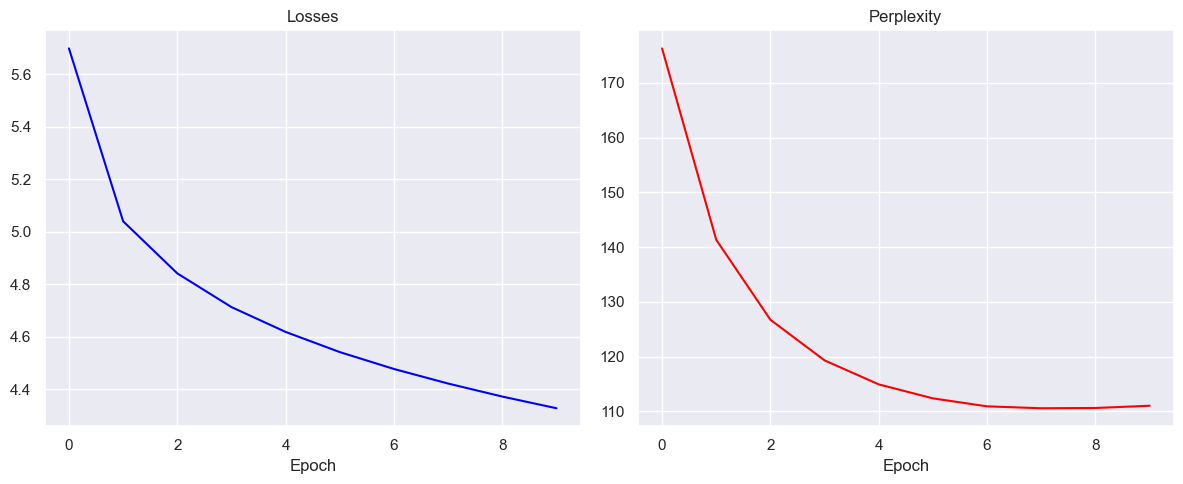

In [19]:
model = LanguageModel_LSTM(hidden_dim=128, vocab_size=len(vocab)).to(device) # Уменьшил скрытый слой до 128 нейронов
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

model = train_model(model, optimizer, criterion, num_epoch=10)

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

| Номер эксперимента | Модель | Размер скрытого слоя | Количество RNN слоев | Perplexity |
| --- | --- | --- | --- | --- |
| 1 | GRU | 256 | 1 |  109 |
| 1.1 | GRU | 512 | 1 | 104 |
| 1.2 | GRU | 256 | 2 | 112 |
| 2 | LSTM | 256 | 1 | 106 | 
| 2.1 | LSTM | 512 | 1 | 102 | 
| 2.2 | LSTM | 128 | 1 | 111 | 

Самый лучший результат показала модель LSTM с одним рекуррентным слоем и скрытым слоем размером 512 нейронов

Самый худший результат показала модель GRU с двумя рекуррентными слоями и скрытым слоем размером 256 нейронов.

При добавлении RNN слоя показатель Perplexity увеличился.


При увеличении размера скрытого слоя показатель Perplexity уменьшается. 

Для улучшения качества моделей, возможно, стоит попробовать увеличить размер скрытого слоя еще сильнее.